In [ ]:
## Version 2025. 04. 18
## Plot QCRB vs. E and B

import numpy as np
from qutip import basis, Qobj, steadystate
import matplotlib.pyplot as plt

# ----------------------------------------
# 1. System parameters (fill as provided)
# ----------------------------------------
hbar   = 1.054571817e-34      # J·s
mu_B   = 9.274009994e-24      # J/T

# Laser Rabi frequencies (rad/s)
Omega_p = 2 * np.pi * 5e6     # Probe
Omega_c = 2 * np.pi * 1e6     # Coupling

# Zeeman g-factors and magnetic field
g_S = 2.0
g_P = 0.67

# theta_B_deg = 45.0            # Magnetic field direction in degrees
# theta_B = np.deg2rad(theta_B_deg)

# RF parameters
f_RF = 6.9e9                  # Hz
e = 1.60217662e-19            # C
a0 = 5.29177210903e-11        # m
d_reduced = e * a0 * 1443.459 # C·m (reduced dipole)

omega_0  = 2 * np.pi * f_RF   # rad/s (reference resonance)
omega_RF = omega_0 + 2*np.pi*0.8e06   # rad/s

# Detunings for probe/coupling
Delta_p = 0.0
Delta_c = 0.0

# Decay rates (rad/s)
Gamma2 = 2 * np.pi * 6.67e6   # |2>→|1>
Gamma3 = 2 * np.pi * 5e3      # |3>→|2>
Gamma4 = 2 * np.pi * 3e3      # |4>→|3>
gamma_34 = (Gamma3 + Gamma4) / 2  # pure dephasing for |4> sublevels

# Electric field amplitude
# E0 = 0.1 # V/m

# ----------------------------------------
# 2. Transition definitions for Zeeman channels
# ----------------------------------------
transitions = [
    {'mJp': +0.5, 'mJ': +0.5, 'q':  0, 'CG': 1/np.sqrt(6), 'phase': +1},
    {'mJp': -0.5, 'mJ': -0.5, 'q':  0, 'CG': 1/np.sqrt(6), 'phase': -1},
    {'mJp': -0.5, 'mJ': +0.5, 'q': +1, 'CG': 1/np.sqrt(6), 'phase': +1},
    {'mJp': +0.5, 'mJ': -0.5, 'q': -1, 'CG': 1/np.sqrt(6), 'phase': -1},
]

def alpha_pol(theta, q):
    if q == +1: return -1/np.sqrt(2) * np.sin(theta)
    if q == -1: return  1/np.sqrt(2) * np.sin(theta)
    if q ==  0: return              np.cos(theta)
    return 0.0

def Omega_RF_components(theta_RF, theta_B):
    comps = []
    for tr in transitions:
        # Zeeman shift with field direction projection
        Delta_Z = (g_P*tr['mJ'] - g_S*tr['mJp']) * mu_B * B_field * np.cos(theta_B) / hbar
        # Effective detuning for this Zeeman channel
        Delta_q = omega_RF - (omega_0 + Delta_Z)
        # Rabi frequency for this channel
        Omega_q = (E0/hbar) * abs(
            alpha_pol(theta_RF, tr['q'])

            * tr['phase']
            * tr['CG']
            * d_reduced
        )
        comps.append((Omega_q, Delta_q, tr['mJp'], tr['mJ']))
    return comps


# 3. Modeling a "6-level" Rydebrg system: g,e,r+,r-,p+,p-
# |3>, m_J = +1/2, r+
# |3>, m_J = -1/2, r-
# |4>, m_J = +1/2, p+
# |4>, m_J = -1/2, p-
labels = ['g','e','r+','r-','p+','p-']
states = {name: basis(6,i) for i,name in enumerate(labels)}
proj   = {k: v*v.dag() for k,v in states.items()}

# Ladder operators
sig_ge = states['g'] * states['e'].dag()
sig_eg = sig_ge.dag()
sig_erp = states['r+'] * states['e'].dag()
sig_rpe = sig_erp.dag()
sig_erm = states['r-'] * states['e'].dag()
sig_rme = sig_erm.dag()

CG_cp_p = 1/np.sqrt(2)
CG_cp_m = 1/np.sqrt(2)

# ----------------------------------------
# 4. Hamiltonian including Zeeman manifold
# ----------------------------------------
def H_system(theta_RF, theta_B):
    # Probe coupling
    H_p = (Omega_p/2) * (sig_ge + sig_eg)
    # Coupling laser
    H_c = (Omega_c/2) * (
        CG_cp_p*(sig_erp + sig_rpe) +
        CG_cp_m*(sig_erm + sig_rme)
    )
    # RF coupling across p sublevels
    H_rf = Qobj(np.zeros((6,6), dtype=complex))
    for Omega_q, _, mJp, mJ in Omega_RF_components(theta_RF, theta_B):
        idx_r = 'r+' if mJp == +0.5 else 'r-'
        idx_p = 'p+' if mJ   == +0.5 else 'p-'
        op_rp = states[idx_r] * states[idx_p].dag()
        H_rf += (Omega_q/2) * (op_rp + op_rp.dag())
    # Detuning terms
    H_det = Delta_p * proj['e'] + Delta_c*(proj['r+'] + proj['r-'])
    for _, Delta_q, _, mJ in Omega_RF_components(theta_RF, theta_B):
        key = 'p+' if mJ == +0.5 else 'p-'
        H_det += Delta_q * proj[key]
    return H_p + H_c + H_rf + H_det

# ----------------------------------------
# 5. Collapse operators for dissipation
# ----------------------------------------
c_ops = [
    np.sqrt(Gamma2) * sig_ge,                               # |2>→|1>
    np.sqrt(Gamma3) * (sig_rpe + sig_rme),                  # |3>→|2>
    np.sqrt(Gamma4) * (states['r+']*states['p+'].dag() + states['r-']*states['p-'].dag()),  # |4>→|3>
    np.sqrt(gamma_34) * proj['p+'],                         # dephasing on p+
    np.sqrt(gamma_34) * proj['p-'],                         # dephasing on p-
]

# ----------------------------------------
# 6. Steady state solver and QFI
# ----------------------------------------
def rho_ss(theta_RF, theta_B):
    return steadystate(H_system(theta_RF, theta_B), c_ops)

def compute_QFI(theta_RF, theta_B, eps=1e-5):
    rho0 = rho_ss(theta_RF, theta_B)
    rho_p = rho_ss(theta_RF + eps, theta_B)
    rho_m = rho_ss(theta_RF - eps, theta_B)
    drho  = (rho_p - rho_m) / (2*eps)
    # Vectorize and apply Šafránek formula
    vec = lambda A: A.full().ravel(order='F')
    M = np.kron(rho0.full().conj(), np.eye(6)) + np.kron(np.eye(6), rho0.full())
    Minv = np.linalg.inv(M + 1e-12*np.eye(36))
    v = vec(drho)
    return 2 * np.real(v.conj() @ Minv @ v)

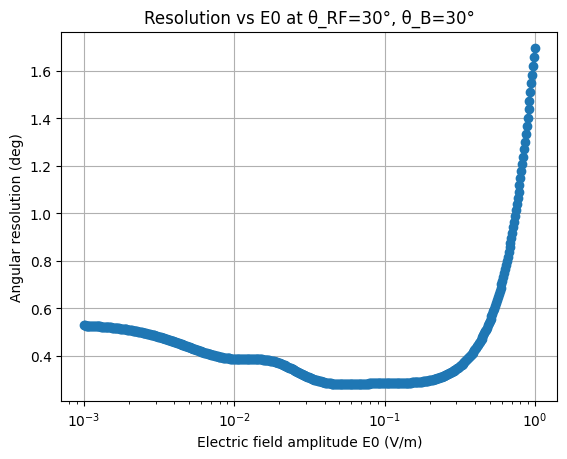

In [24]:
nu = 1e4     # Number of repeats (can relate to measurement integration time × bandwidth)
eps = 1e-5   # Numerical differentiation step

from scipy.signal import medfilt

## Plot resolution vs E
# Fixed angles
theta_RF = np.deg2rad(30)  # fixed polarization angle
theta_B  = np.deg2rad(30)  # fixed magnetic field direction
B_field  = 0.2e-4          # Fixed magnetic field

# V2: using 9-point mid-filtering
# Sweep electric field amplitude E0 (V/m)
E0_values = np.logspace(-3, 0, 500)  # 0.01 to 1 V/m
res_vs_E0 = np.zeros_like(E0_values)
qfi_cut   = 5e-3   

for i, E0_val in enumerate(E0_values):
    # Update E0
    globals()['E0'] = E0_val
    F = compute_QFI(theta_RF, theta_B, eps)
    if F < qfi_cut:
        res_vs_E0[i] = np.nan
    else:
        res_vs_E0[i] = np.degrees(np.sqrt(1/(nu*F))) # np.degrees, rad to deg

# Mid-value filtering
# res_vs_E0 = medfilt(res_vs_E0, kernel_size=9)

# Plot
plt.figure()
plt.plot(E0_values, res_vs_E0, '-o')
plt.xscale('log')
plt.xlabel('Electric field amplitude E0 (V/m)')
plt.ylabel('Angular resolution (deg)')
plt.title('Resolution vs E0 at θ_RF=30°, θ_B=30°')
plt.grid(True)
plt.show()



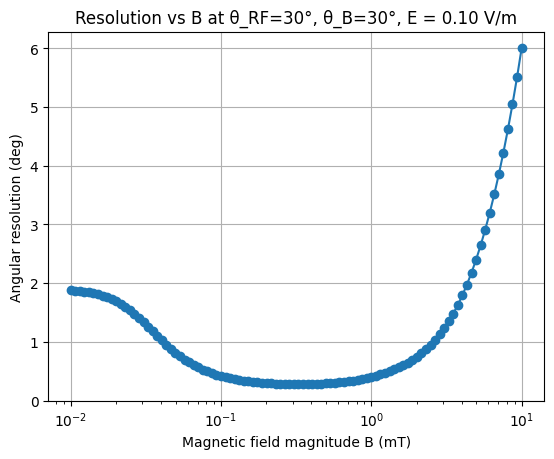

In [22]:
## Plot resolution vs B
# Sweep magnetic field magnitude B_field (Tesla)
B_values = np.logspace(-5, -2, 100)  # 0.01 mT to 10 mT in Tesla
res_vs_B = np.zeros_like(B_values)
E = 0.1 # fixed electric field

for i, B_val in enumerate(B_values):
    B_field = B_val  # update global B_field
    F = compute_QFI(theta_RF, theta_B)
    res_vs_B[i] = np.degrees(np.sqrt(1.0/(nu * F)))

# Plot resolution vs B_field
plt.figure()
plt.plot(B_values*1e3, res_vs_B, '-o')  # x-axis in mT
plt.xlabel('Magnetic field magnitude B (mT)')
plt.ylabel('Angular resolution (deg)')
plt.title(f'Resolution vs B at θ_RF=30°, θ_B=30°, E = {E:.2f} V/m')
plt.xscale('log')
plt.grid(True)
plt.show()
